### This notebook showcases our analysis of the blogposts using clustering techniques.  We also included an interactive visualization tool, where the user specifies the number of clusters it wants to use for the k means algorithm, and the function plots the distribution of clusters by gender

In [47]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.metrics.pairwise import cosine_similarity


### Clustering with blogs by same author separate

In [125]:
db = pd.read_csv('sample3.csv')

In [5]:
db.head()

,chap_num,para_num,sent_num,token_num,pos,token_str,punc,num,gender,topic,id
0,141,0,0,0,WDT,whatever,0,0,male,Non-Profit,3705830
1,141,0,0,1,PRP,it,0,0,male,Non-Profit,3705830
2,141,0,0,2,VBZ,is,0,0,male,Non-Profit,3705830
3,141,0,0,3,PRP,they,0,0,male,Non-Profit,3705830
4,141,0,0,4,VBD,put,0,0,male,Non-Profit,3705830


In [14]:
#create dfidf for feature representation

#retaining labels
db_mapping = db[['chap_num','gender','id']].copy()
db_mapping.drop_duplicates(inplace=True)
print(len(db_mapping))
db_mapping.head()

#Aggregating corpus
db.token_str = db.token_str.astype('str')
cdb = db.groupby('chap_num')\
    .apply(lambda x: ' '.join(x.token_str))\
    .to_frame()\
    .rename(columns={0:'text'})
cdb.head()

#Merginig db
dbm = pd.merge(cdb,db_mapping,left_index=True,right_on='chap_num')

#TFIDF
vect = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(dbm['text'])
X_train_word = vect.transform(dbm['text'])

dbm.head()

10000


,text,chap_num,gender,id
1204097,O= optimist P= pessimist My argument with myse...,74,female,3539003
0,whatever it is they put into freeze pops to ma...,141,male,3705830
215,"& nbsp ; in my head , and in response to an em...",145,male,3705830
911,Friends are like ships Anchored their lines by...,220,male,3429420
958,There have been times in my life when I have f...,226,male,3429420


In [23]:
tfidf = X_train_word.toarray()

In [ ]:
NUM_CLUSTERS=4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(tfidf, assign_clusters=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
dbm['gender_ohe'] = labelencoder_X_1.fit_transform(dbm.loc[:,'gender'])

In [ ]:
sum(dbm['gender_ohe']!=assigned_clusters)

In [ ]:
dbm['gender_ohe'].value_counts()

In [112]:
assigned_clusters = pd.DataFrame(assigned_clusters)

In [113]:
dbm2 = dbm.reset_index()

In [114]:
assigned_clusters['gender'] = dbm2['gender']

In [115]:
female = assigned_clusters[assigned_clusters['gender'] == 'female']
male = assigned_clusters[assigned_clusters['gender'] == 'male']

In [116]:
female[0].value_counts()

3    2107
2    1872
0     735
1     286
Name: 0, dtype: int64

In [117]:
male[0].value_counts()

2    1971
3    1929
0     942
1     158
Name: 0, dtype: int64

Conclusion:  There is some small differentiation by gender but it is difficult to tell if it is real or noise

### clusters after concatenating posts by same author

In [157]:
db = pd.read_csv('sampleorig.csv')

db = db[['gender','text','id']]

dbm = db.groupby(['gender','id'])\
    .apply(lambda x: ' '.join(x.text))\
    .to_frame()\
    .rename(columns={0:'text'})
dbm.reset_index(inplace=True)
dbm.head()

dbm.text = dbm.text.str.replace('urllink'," ")
dbm.text = dbm.text.str.replace('nbsp'," ")

In [158]:
#TFIDF
vect = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(dbm['text'])
X_train_word = vect.transform(dbm['text'])

In [159]:
tfidf = X_train_word.toarray()

In [170]:
NUM_CLUSTERS=2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(tfidf, assign_clusters=True)

In [171]:
assigned_clusters = pd.DataFrame(assigned_clusters)
dbm2 = dbm.reset_index()
assigned_clusters['gender'] = dbm2['gender']
female = assigned_clusters[assigned_clusters['gender'] == 'female']
male = assigned_clusters[assigned_clusters['gender'] == 'male']

In [172]:
female[0].value_counts()

1    1653
0     219
Name: 0, dtype: int64

In [173]:
male[0].value_counts()

1    1511
0     329
Name: 0, dtype: int64

Conclusion: There is a bit more differentiation seen here, with more male in cluster 0 and more female in cluster 1.  Still lots of noise

# Interactive Function(K means Clustering)

In [3]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


db = pd.read_csv('sampleorig.csv')

db = db[['gender','text','id']]

dbm = db.groupby(['gender','id'])\
    .apply(lambda x: ' '.join(x.text))\
    .to_frame()\
    .rename(columns={0:'text'})
dbm.reset_index(inplace=True)
dbm.head()

dbm.text = dbm.text.str.replace('urllink'," ")
dbm.text = dbm.text.str.replace('nbsp'," ")

vect = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(dbm['text'])
X_train_word = vect.transform(dbm['text'])

tfidf = X_train_word.toarray()


#assumes tfidf is already created
#also assumes dbm object available with values for gender

#occassionally, throws assertion error, rerunning should solve the issue
def plotclusters(numclust):
    import warnings
    warnings.filterwarnings('ignore')
    #create clusters
    NUM_CLUSTERS=numclust
    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
    assigned_clusters = kclusterer.cluster(tfidf, assign_clusters=True)
    
    #add gender values to cluster df
    assigned_clusters = pd.DataFrame(assigned_clusters)
    dbm2 = dbm.reset_index()
    assigned_clusters['gender'] = dbm2['gender']
    
    #create counts for num of each gender in diff clusters
    female = assigned_clusters[assigned_clusters['gender'] == 'female']
    male = assigned_clusters[assigned_clusters['gender'] == 'male']
    fplot = female[0].value_counts()
    fplot = fplot.sort_index()
    mplot = male[0].value_counts()
    mplot = mplot.sort_index()
    flist = fplot.tolist()
    mlist = mplot.tolist()
    
    #plot
    N = numclust
    men_means = mlist


    ind = np.arange(N)  
    width = 0.35       

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, men_means, width, color='b')

    women_means = flist

    rects2 = ax.bar(ind + width, women_means, width, color='g')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Num Authors')
    ax.set_title('Clusters by gender')
    ax.set_xticks(ind + width / 2)
    numlist = [str(x) for x in range(numclust)]
    ax.set_xticklabels(numlist)

    ax.legend((rects1[0], rects2[0]), ('Male', 'Female'))

    plt.show()

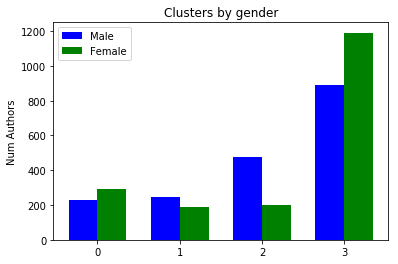

In [4]:
# To use the tool, change number_clusters to the number of clusters you want.  
# The function may take a minute to run so be patient
# It also requires that the previous cell is run first
# Sometimes the clustering package throws an assert error.  Just rerun the function if it happens.

number_clusters = 4

plotclusters(number_clusters)